This notebook focuses on the initial exploration of basic model architectures.

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt #for displaying plots
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import *
from keras.callbacks import *
from keras import regularizers
from keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
import datetime
import random
import properscoring as ps

from scipy.stats import norm

import shap
import xgboost
import pydot
import graphviz
import os

In [2]:
# setting a seed to ensure reproducability and consistency
random.seed(16)
np.random.seed(16)
tf.random.set_seed(16)

In [3]:
# Change Working Directory
os.chdir("..")
print(os.getcwd()) # print current working directory

c:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Probabilistic-Forecasting-of-Bicycle-Counts-in-Karlsruhe-with-Neural-Networks


In [4]:
X_train = pd.read_pickle(r"data\X_train.pkl")
X_valid = pd.read_pickle(r"data\X_valid.pkl")
X_test = pd.read_pickle(r"data\X_test.pkl")

X_train_num = pd.read_pickle(r"data\X_train_num.pkl")
X_valid_num = pd.read_pickle(r"data\X_valid_num.pkl")
X_test_num = pd.read_pickle(r"data\X_test_num.pkl")

y_train = pd.read_pickle(r"data\y_train.pkl")
y_valid = pd.read_pickle(r"data\y_valid.pkl")
y_test = pd.read_pickle(r"data\y_test.pkl")

In [5]:
X_train['date'] =  pd.to_datetime(X_train['date'])
X_valid['date'] =  pd.to_datetime(X_valid['date'])
X_test['date'] =  pd.to_datetime(X_test['date'])

# Functions

In [ ]:
# This function was provided by Tobias Biegert
def crps_normal_cost_function(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]
    
    # Split input
    mu = y_pred[:, 0]
    var = tf.square(y_pred[:, 1]) # Ensure standard deviation is positive
    sigma = tf.sqrt(var)  
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [7]:
def crps_normal_cost_function_v2(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]

    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [8]:
def predict_and_calculate_mean_crps(model, X_test = X_test_num, y_test = y_test, print_predicted_mean_std = False):
    """Make predictions on test data and calculate mean CRPS.

    Args:
        model: Trained model
        X_test: Test data
        y_test: True values
        print_predicted_mean_std: Boolean to print predicted mean and std

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
     
    predicted_mean_std = model.predict(X_test)
    if print_predicted_mean_std:
        print(predicted_mean_std)
    
    predicted_mean = predicted_mean_std[:, 0]
    predicted_std = predicted_mean_std[:, 1]
    mean_crps = np.mean(ps.crps_gaussian(y_test, mu=predicted_mean, sig=predicted_std))
    print(f"\nMean CRPS: { mean_crps }")


    return mean_crps, predicted_mean_std

In [9]:
def compile_and_fit_model(model, X_train = X_train_num, y_train = y_train, X_valid = X_valid_num, y_valid = y_valid,  pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10):
    """Compile and fit a model on training data.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size

    Returns:
        model: Trained model
    """

    #print some information about the model
    print('Model information:\n\nCallbacks: EarlyStopping (patience: ' + str(pat) + '), Learning Rate (Reduce on Plateau, patience: ' + str(pat) + ')\nBatch size: ' + str(batch_size) + '\nEpochs: ' + str(epochs) + '\n')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=pat, 
                                                      restore_best_weights=True)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.2,
                                                     patience = pat,
                                                     min_lr=0 )
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_function)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[early_stopping, reduce_lr])

    return model, history

In [10]:
def plot_loss(history):
    """Plot training and validation loss.

    Args:
        history: History object
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [11]:
def process_model(model, X_train,  X_valid, X_test, y_train = y_train, y_valid = y_valid, y_test = y_test, pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10, print_predicted_mean_std = False, plot_loss_flag = True):
    """Compile, fit and evaluate a model.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        X_test: Test data
        y_test: Test targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size
        print_predicted_mean_std: Boolean to print predicted mean and std
"""

    model, history = compile_and_fit_model(model, X_train, y_train, X_valid, y_valid,  pat, lr, loss_function, epochs, batch_size)

    mean_crps, predicted_mean_std = predict_and_calculate_mean_crps(model, X_test, y_test, print_predicted_mean_std)

    if plot_loss_flag:
        plot_loss(history)

    return model, mean_crps, history, predicted_mean_std

In [12]:
def check_positive_std_devs(std_devs):
    """Check if all standard deviations are positive (since there might be errors in the model calculation).
    Args:
        std_devs: Standard deviations
    """
    
    # Check if any standard deviations are non-positive
    if np.any(std_devs <= 0):
        raise ValueError("All standard deviations must be positive and non-zero.")
    

# Neural Networks

## Initial Testing

In [13]:
 # Initialize the model
model = Sequential()

# Add output layer: 2 neurons (mean, std), no hidden layers
model.add(Dense(units=2, input_shape=(X_train_num.shape[1],)))

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model, history = compile_and_fit_model(model)

Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 100

Epoch 1/100


317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4750.0898 - val_loss: 4497.0049 - learning_rate: 0.0010
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4746.6968 - val_loss: 4493.6108 - learning_rate: 0.0010
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4743.3159 - val_loss: 4490.2231 - learning_rate: 0.0010
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4739.9385 - val_loss: 4486.8364 - learning_rate: 0.0010
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4736.5625 - val_loss: 4483.4521 - learning_rate: 0.0010
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4733.1870 - val_loss: 4480.0684 - learning_rate: 0.0010
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4729.8140 - val_loss: 4476.6851 - learning_rate: 0.0010
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4726.4409 - val_loss: 4473.3013 - learning_rate: 0.0010
Epoch 9/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4723.0674 - val

In [15]:
mean_crps = predict_and_calculate_mean_crps(model) 

 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Mean CRPS: 4070.1629947333117


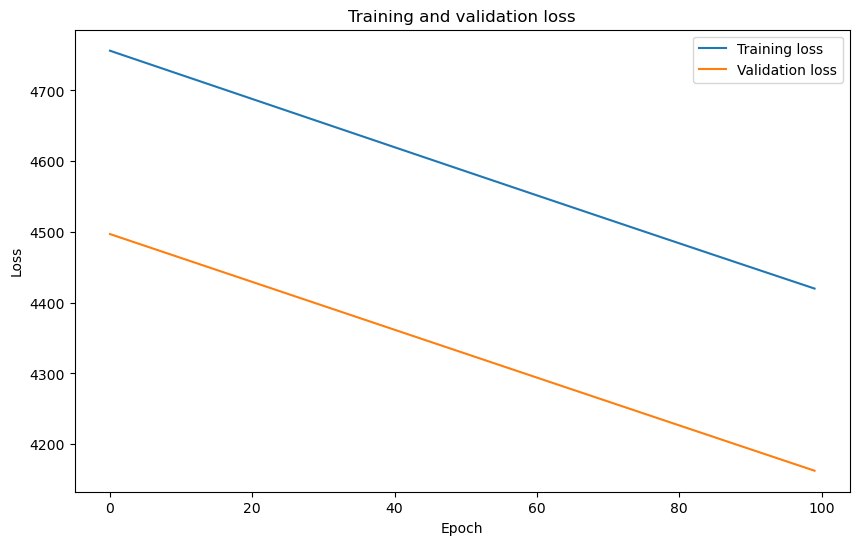

In [16]:
plot_loss(history)

Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 20

Epoch 1/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4414.3184 - val_loss: 4159.0190 - learning_rate: 0.0010
Epoch 2/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4410.9824 - val_loss: 4155.6465 - learning_rate: 0.0010
Epoch 3/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4407.6621 - val_loss: 4152.2759 - learning_rate: 0.0010
Epoch 4/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4404.3442 - val_loss: 4148.9082 - learning_rate: 0.0010
Epoch 5/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4401.0298 - val_loss: 4145.5405 - learning_rate: 0.0010
Epoch 6/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4397.7178 - val_loss: 4142.1753 - learning_rate: 0.0010
Epoch 7/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4394.4062 - val_loss: 4138.8105 - learning_rate: 0.0010
Epoch 8/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

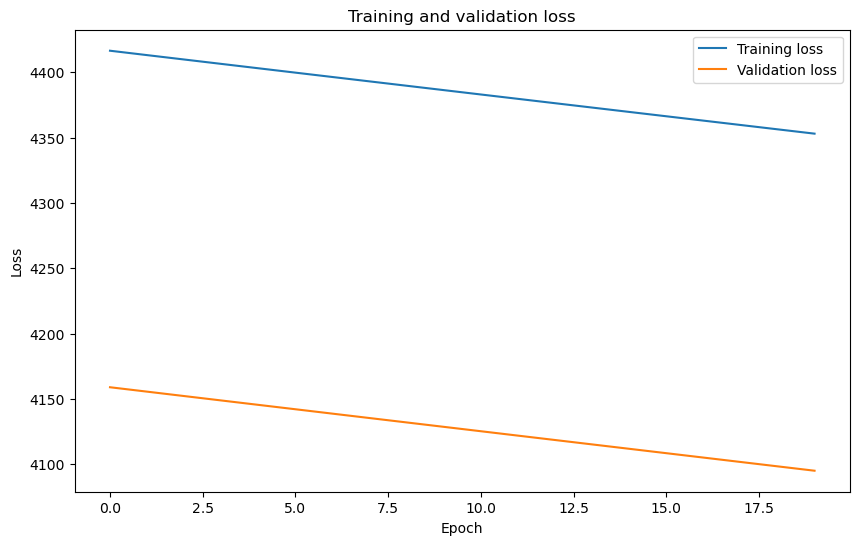

In [17]:
model, mean_crps, history, predicted_means_std = process_model(model, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs=20) 

In [18]:
model1 = Sequential([
    Dense(256, input_shape=(X_train_num.shape[1],), activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 100

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2795.6492 - val_loss: 693.6204 - learning_rate: 0.0010
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 620.2838 - val_loss: 601.4666 - learning_rate: 0.0010
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 586.0752 - val_loss: 603.6622 - learning_rate: 0.0010
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 570.2706 - val_loss: 581.8688 - learning_rate: 0.0010
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 548.7390 - val_loss: 578.2613 - learning_rate: 0.0010
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 546.2581 - val_loss: 572.2715 - learning_rate: 0.0010
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 538.5656 - val_loss: 581.5640 - learning_rate: 0.0010
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss

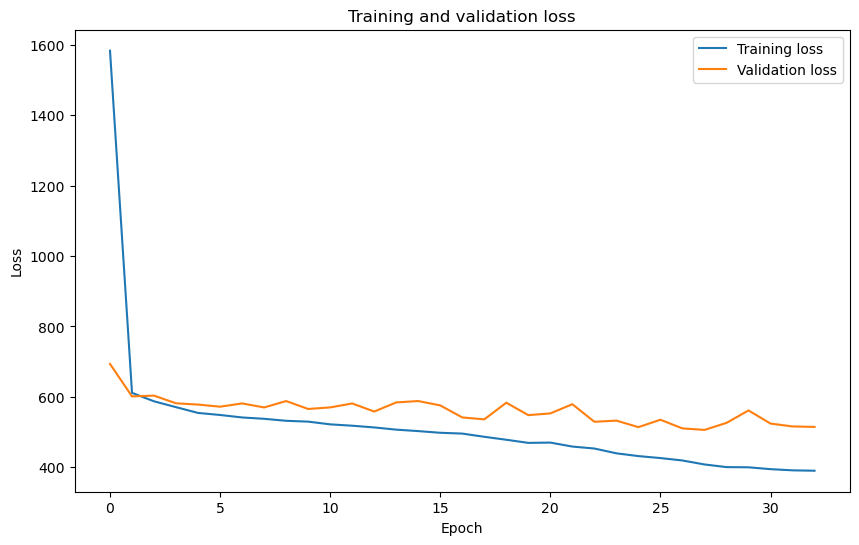

In [19]:
model1, mean_crps1, history1, predicted_means_std1 = process_model(model1, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, loss_function=crps_normal_cost_function_v2) 

In [20]:
model2 = Sequential([
    Dense(256, input_shape=(X_train_num.shape[1],), activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 100

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2841.3535 - val_loss: 701.4571 - learning_rate: 0.0010
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 618.1736 - val_loss: 588.9729 - learning_rate: 0.0010
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 582.7880 - val_loss: 566.6168 - learning_rate: 0.0010
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 564.1309 - val_loss: 587.6343 - learning_rate: 0.0010
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 553.1777 - val_loss: 590.4326 - learning_rate: 0.0010
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 540.3691 - val_loss: 575.5325 - learning_rate: 0.0010
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 541.6616 - val_loss: 583.9451 - learning_rate: 0.0010
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss

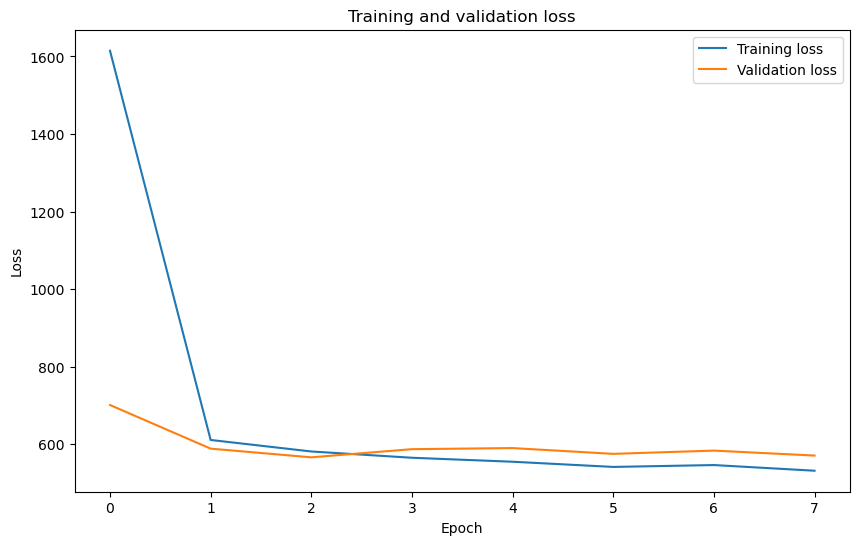

In [21]:
model2, mean_crps2, history2, predicted_means_std2 = process_model(model2, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num) 

In [22]:
model3 = Sequential([
    Dense(256, input_shape=(X_train_num.shape[1],), activation='relu'),
    Dense(256, activation='softplus'),
    Dropout(0.2),
    Dense(256, activation='sigmoid'),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 100

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4723.7578 - val_loss: 4416.4751 - learning_rate: 0.0010
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4647.9268 - val_loss: 4342.3672 - learning_rate: 0.0010
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4573.8965 - val_loss: 4268.8560 - learning_rate: 0.0010
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4500.5557 - val_loss: 4195.3564 - learning_rate: 0.0010
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4426.9365 - val_loss: 4121.4937 - learning_rate: 0.0010
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4353.5107 - val_loss: 4048.2988 - learning_rate: 0.0010
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4280.7310 - val_loss: 3975.5024 - learning_rate: 0.0010
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4m

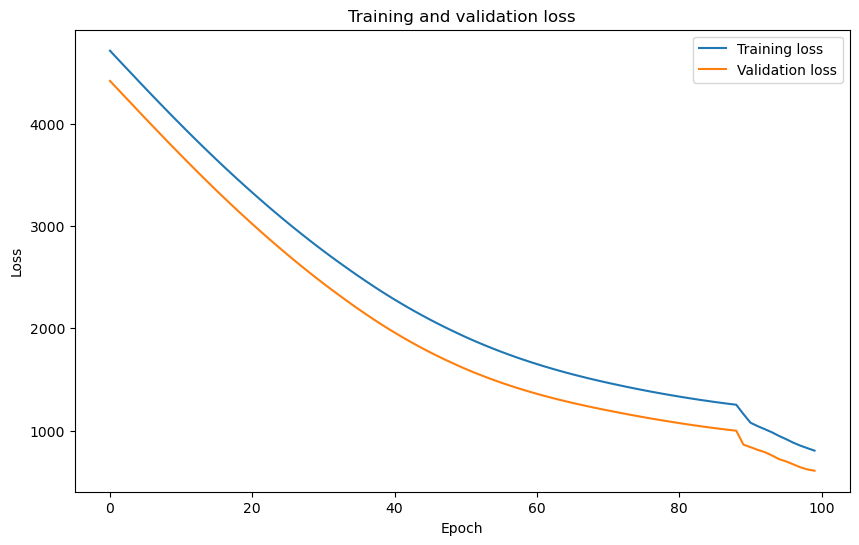

In [23]:
model3, mean_crps3, history3, predicted_means_std3 = process_model(model3, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num) 

In [24]:
model4 = Sequential([
    Dense(256, input_shape=(X_train_num.shape[1],), activation='relu'),
    Dense(256, activation='softplus'),
    Dropout(0.2),
    Dense(256, activation='sigmoid'),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 100

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4724.4673 - val_loss: 4416.1255 - learning_rate: 0.0010
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4646.6089 - val_loss: 4338.8652 - learning_rate: 0.0010
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4569.8145 - val_loss: 4262.6216 - learning_rate: 0.0010
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4493.0938 - val_loss: 4185.1997 - learning_rate: 0.0010
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4416.1870 - val_loss: 4108.0474 - learning_rate: 0.0010
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4339.2544 - val_loss: 4031.5183 - learning_rate: 0.0010
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4263.2583 - val_loss: 3955.6265 - learning_rate: 0.0010
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4m

c:\Users\aisti\anaconda3\Lib\site-packages\properscoring\_crps.py:66: RuntimeWarning: divide by zero encountered in divide
  sx = (x - mu) / sig
c:\Users\aisti\anaconda3\Lib\site-packages\properscoring\_crps.py:72: RuntimeWarning: invalid value encountered in multiply
  crps = sig * (sx * (2 * cdf - 1) + 2 * pdf - pi_inv)


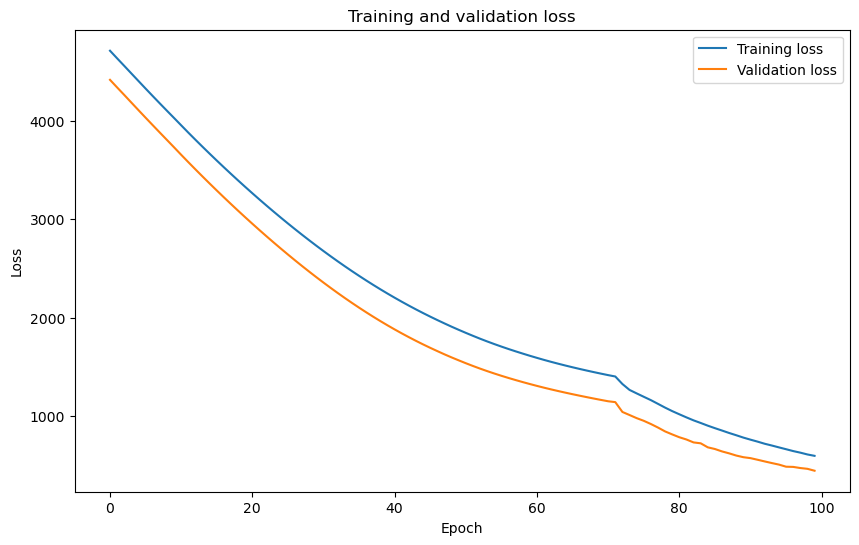

In [25]:
model4, mean_crps4, history4, predicted_means_std4 = process_model(model4, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, loss_function=crps_normal_cost_function_v2) 

In [26]:
model5 = Sequential([
    Dense(256, input_shape=(X_train_num.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 100

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 2147.9539 - val_loss: 585.5808 - learning_rate: 0.0010
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 637.4734 - val_loss: 604.0402 - learning_rate: 0.0010
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 610.0508 - val_loss: 587.4391 - learning_rate: 0.0010
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 592.2114 - val_loss: 578.3524 - learning_rate: 0.0010
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 579.5662 - val_loss: 571.2509 - learning_rate: 0.0010
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 561.8029 - val_loss: 524.3222 - learning_rate: 0.0010
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 536.9994 - val_loss: 539.5613 - learning_rate: 0.0010
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss

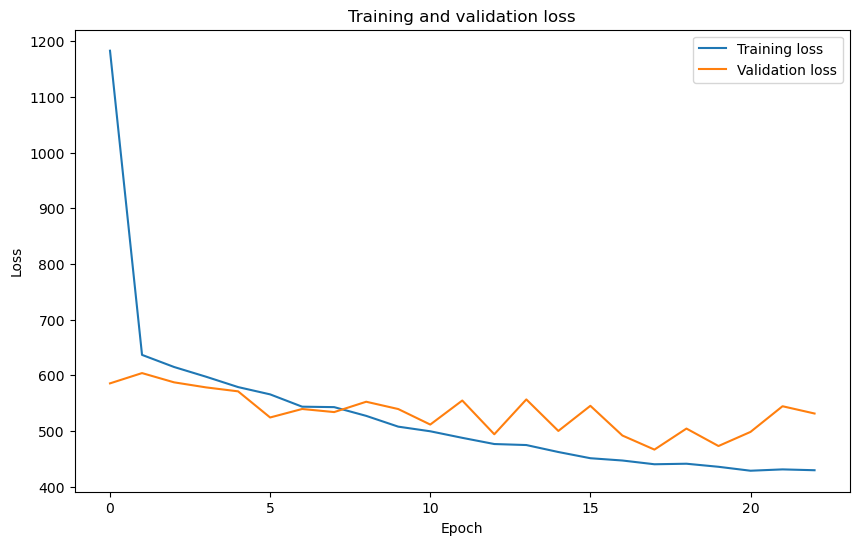

In [27]:
model5, mean_crps5, history5, predicted_means_std5 = process_model(model5, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, print_predicted_mean_std=True) 

In [28]:
model6 = Sequential([
    Dense(128, input_shape=(X_train_num.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 2232.3145 - val_loss: 562.9532 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 742.7881 - val_loss: 595.0364 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 714.5795 - val_loss: 566.8241 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 688.1832 - val_loss: 657.2985 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 654.0038 - val_loss: 518.9292 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 656.8989 - val_loss: 545.3123 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 648.0317 - val_loss: 491.3327 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss

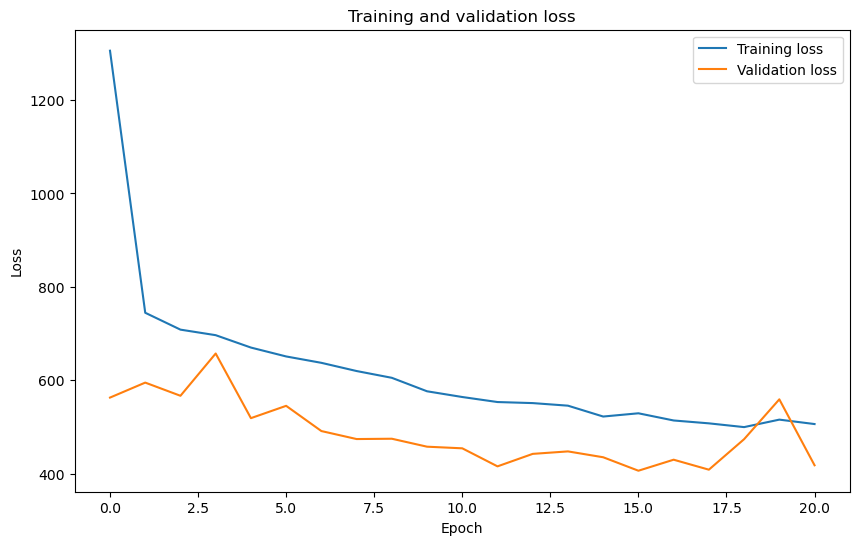

In [29]:
model6, mean_crps6, history6, predicted_means_std6 = process_model(model6, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs=200) 

In [30]:
model7 = Sequential([
    Dense(128, input_shape=(X_train_num.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 100

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2258.7256 - val_loss: 679.7621 - learning_rate: 0.0010
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 747.0925 - val_loss: 592.8475 - learning_rate: 0.0010
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 711.7781 - val_loss: 498.8182 - learning_rate: 0.0010
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 671.6653 - val_loss: 506.4466 - learning_rate: 0.0010
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 686.9783 - val_loss: 479.6652 - learning_rate: 0.0010
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 649.6279 - val_loss: 485.7209 - learning_rate: 0.0010
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 638.1151 - val_loss: 518.7656 - learning_rate: 0.0010
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss

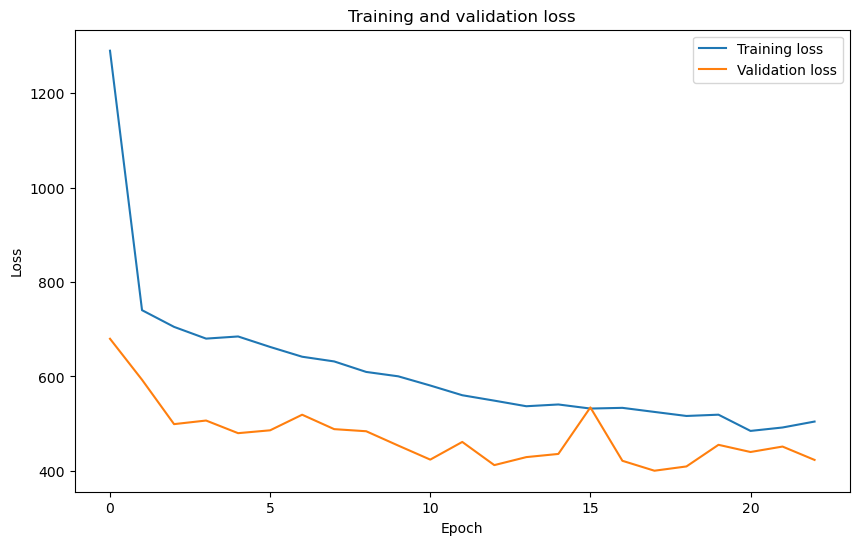

In [31]:
model7, mean_crps7, history7, predicted_means_std7 = process_model(model7, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, loss_function=crps_normal_cost_function_v2) 

In [32]:
model8 = Sequential([
    Dense(256, input_shape=(X_train_num.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1892.7576 - val_loss: 630.3169 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 693.6095 - val_loss: 497.1447 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 700.8651 - val_loss: 677.0858 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 661.0353 - val_loss: 511.8451 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 642.2690 - val_loss: 493.1781 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 633.1262 - val_loss: 495.3352 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 582.0511 - val_loss: 483.1250 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss

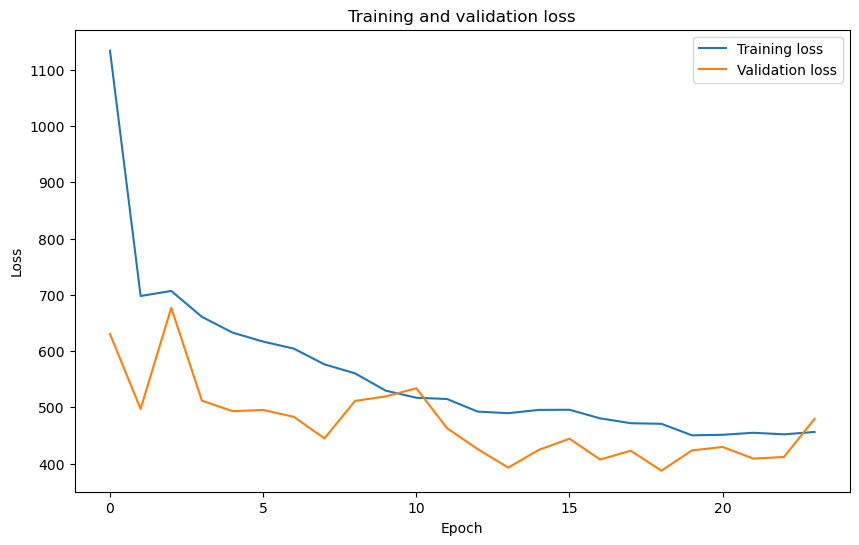

In [33]:
model8, mean_crps8, history8, predicted_means_std8 = process_model(model8, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200) 

In [ ]:
model9 = Sequential([
    Dense(256, input_shape=(X_train_num.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 100

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 1856.1746 - val_loss: 572.0433 - learning_rate: 0.0010
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 732.9268 - val_loss: 516.5940 - learning_rate: 0.0010
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 702.3792 - val_loss: 578.4869 - learning_rate: 0.0010
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 660.8816 - val_loss: 515.8400 - learning_rate: 0.0010
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 646.9622 - val_loss: 657.5464 - learning_rate: 0.0010
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 609.1690 - val_loss: 515.9584 - learning_rate: 0.0010
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 590.0430 - val_loss: 510.2412 - learning_rate: 0.0010
Epoch 8/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss

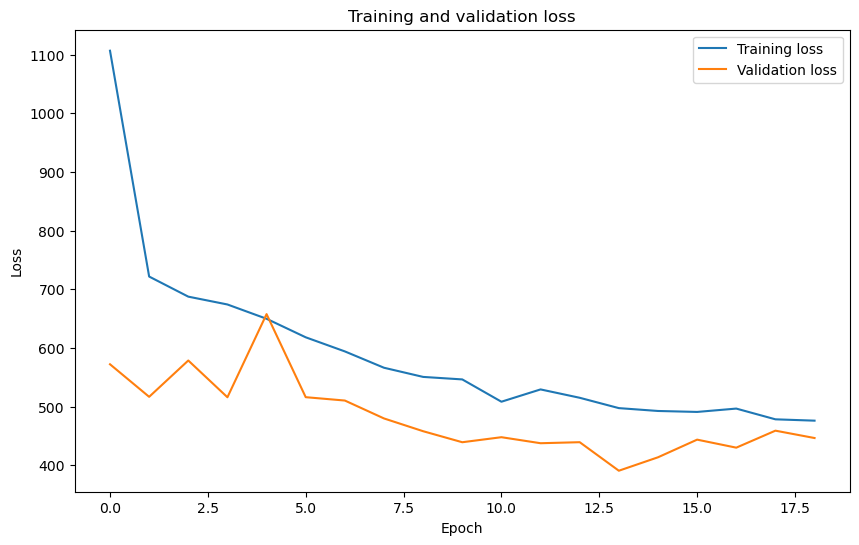

In [35]:
model9, mean_crps9, history9, predicted_means_std9 = process_model(model9, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, loss_function=crps_normal_cost_function_v2) 

In [36]:
model9.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                │ (None, 256)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,592,840 (6.08 MB)

 Trainable params: 530,946 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,061,894 (4.05 MB)

In [37]:
with open(r'Figures\(06) Initial_NN_Testing\model9_summary.txt', 'w') as f:
    model9.summary(print_fn=lambda x: f.write(x + '\n'))

In [ ]:
print(type(model9))  # Check if the model is an instance of keras.Model

<class 'keras.src.models.sequential.Sequential'>


<>:1: SyntaxWarning: invalid escape sequence '\('
<>:1: SyntaxWarning: invalid escape sequence '\('
C:\Users\aisti\AppData\Local\Temp\ipykernel_31956\2067588809.py:1: SyntaxWarning: invalid escape sequence '\('
  plot_model(model9, to_file="Figures\(06) Initial_NN_Testing\model9_architecture.png", show_shapes=True, dpi=96)


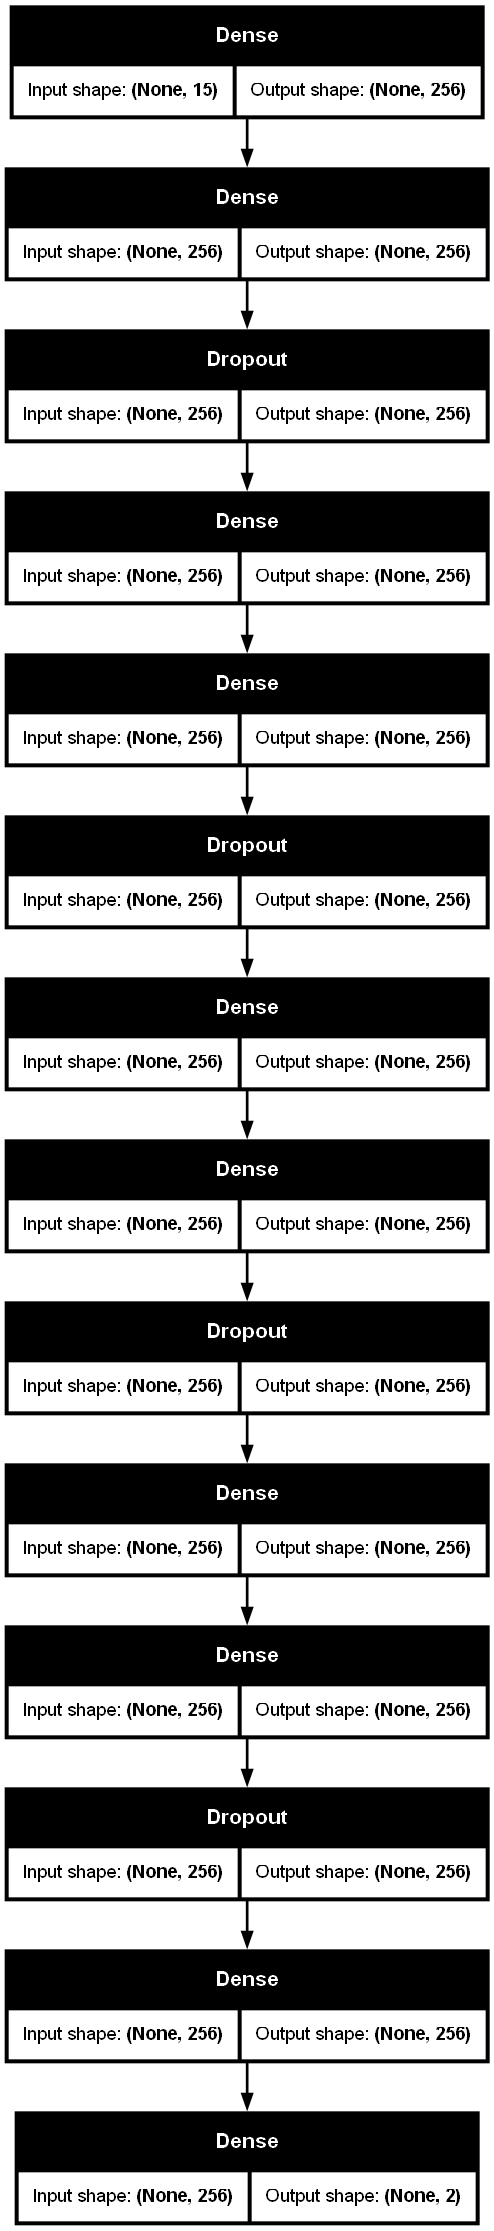

In [39]:
plot_model(model9, to_file="Figures\(06) Initial_NN_Testing\model9_architecture.png", show_shapes=True, dpi=96)

In [40]:
model10 = Sequential([
    Dense(256, input_shape=(X_train_num.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 1953.3713 - val_loss: 594.5223 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 866.0091 - val_loss: 591.4750 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 776.7206 - val_loss: 512.4781 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 770.1550 - val_loss: 573.0363 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 725.1209 - val_loss: 537.6341 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 633.4371 - val_loss: 473.7317 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 626.9260 - val_loss: 506.0689 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - l

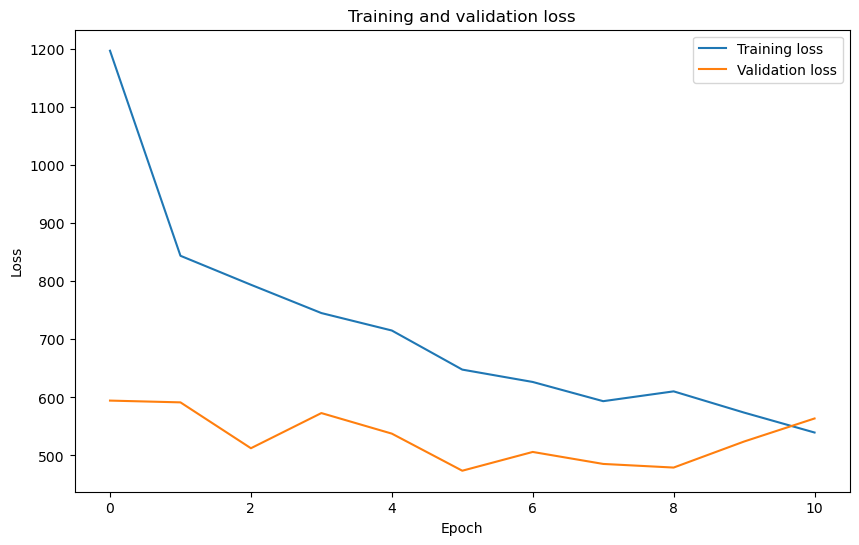

In [41]:
model10, mean_crps10, history10, predicted_means_std10 = process_model(model10, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200) 

In [42]:
X_train_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,0,0,1,0,2
1,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,0,0,1,0,3
2,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,0,0,1,0,4
3,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,0,0,0,0,5
4,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,0,0,0,0,6


In [43]:
X_train_num.columns

Index(['temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
       'precipitation', 'sun', 'windspeed_max', 'precip_indic',
       'school_holiday_indicator', 'public_holiday_indicator',
       'holiday_indicator', 'is_workday', 'season', 'day_of_week'],
      dtype='object')

In [44]:
model11 = Sequential([
    Dense(256, input_shape=(X_train_num.shape[1],), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 1954.4468 - val_loss: 639.9101 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 764.3191 - val_loss: 523.6829 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 744.7490 - val_loss: 523.2919 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 728.3965 - val_loss: 575.8904 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 704.0299 - val_loss: 508.2477 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 651.6923 - val_loss: 427.7255 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 611.5681 - val_loss: 683.0482 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - 

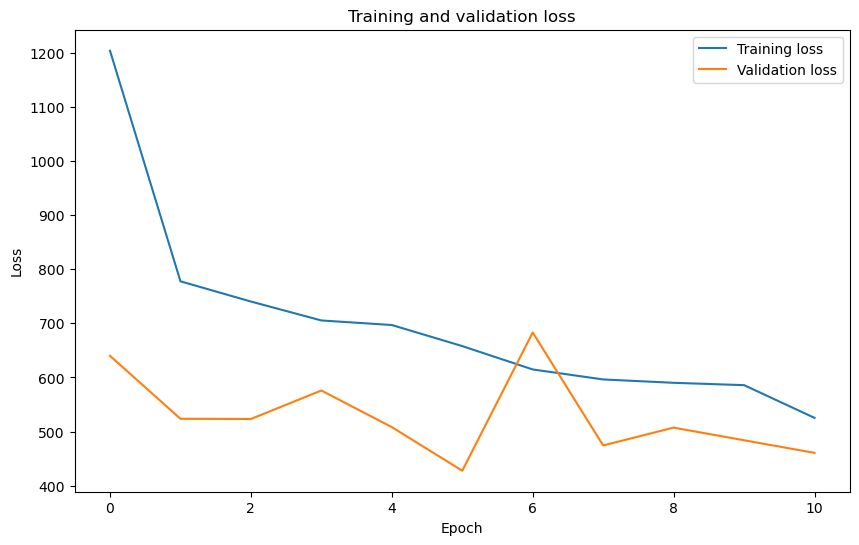

In [45]:
model11a, mean_crps11, history11, predicted_means_std11 = process_model(model11, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [46]:
model11a.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 256)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,184,968 (8.33 MB)

 Trainable params: 728,322 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,456,646 (5.56 MB)

In [47]:
with open(r'Figures\(06) Initial_NN_Testing\model11a_summary.txt', 'w') as f:
    model11a.summary(print_fn=lambda x: f.write(x + '\n'))

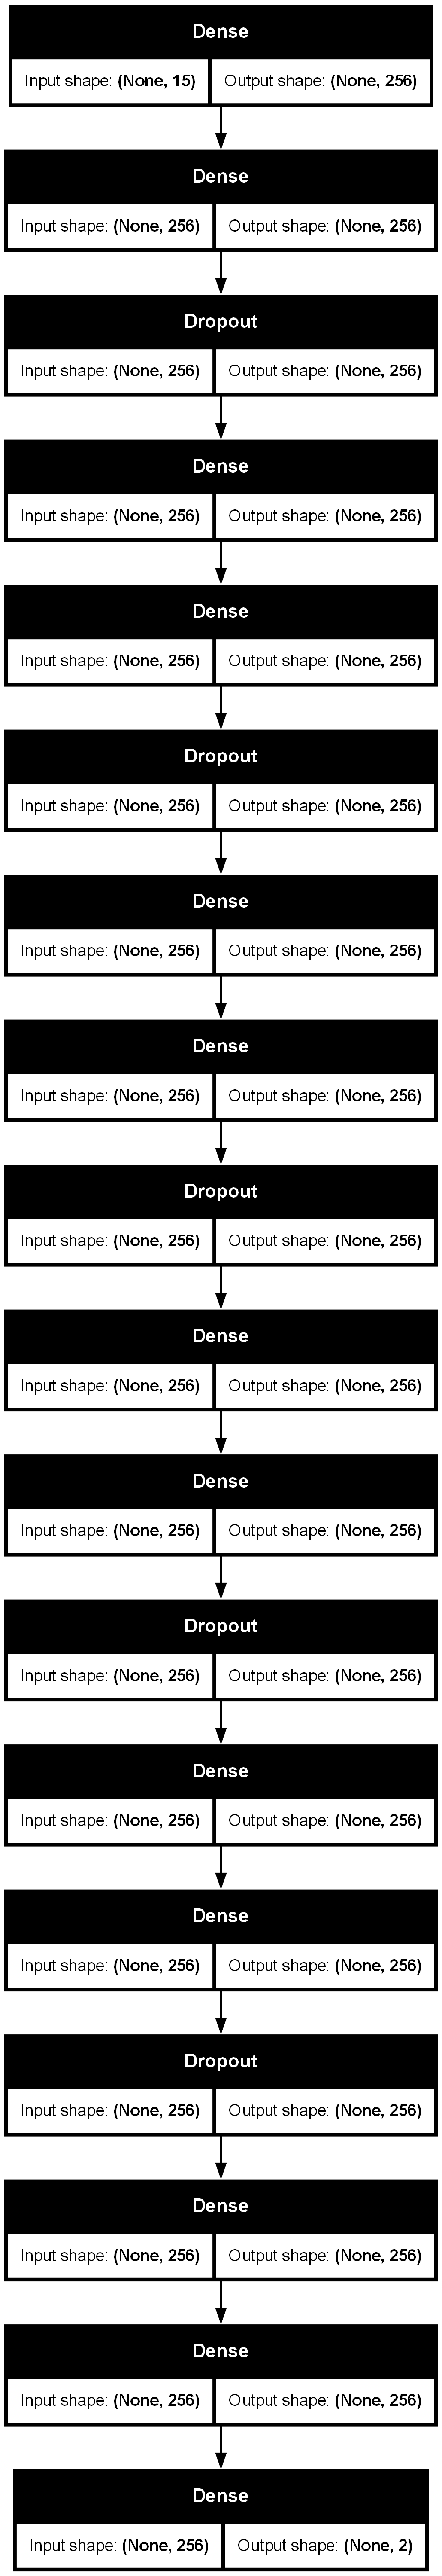

In [48]:
plot_model(model11a, to_file=r"Figures\(06) Initial_NN_Testing\model11a_architecture.png", show_shapes=True)